<a href="https://colab.research.google.com/github/pseudo-xy/pseudo-xy/blob/main/neural_net_for_classification_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
upload = files.upload()

Saving hotel.csv to hotel.csv


In [5]:
import pandas as pd 
hotel = pd.read_csv('hotel.csv')
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


Epoch 1/200
175/175 [==============================] - 6s 22ms/step - loss: 0.4822 - binary_accuracy: 0.7726 - val_loss: 0.4328 - val_binary_accuracy: 0.8025
Epoch 2/200
175/175 [==============================] - 4s 23ms/step - loss: 0.4242 - binary_accuracy: 0.8010 - val_loss: 0.3993 - val_binary_accuracy: 0.8125
Epoch 3/200
175/175 [==============================] - 4s 24ms/step - loss: 0.4086 - binary_accuracy: 0.8095 - val_loss: 0.3933 - val_binary_accuracy: 0.8176
Epoch 4/200
175/175 [==============================] - 3s 20ms/step - loss: 0.4032 - binary_accuracy: 0.8105 - val_loss: 0.3924 - val_binary_accuracy: 0.8179
Epoch 5/200
175/175 [==============================] - 3s 20ms/step - loss: 0.3960 - binary_accuracy: 0.8155 - val_loss: 0.3864 - val_binary_accuracy: 0.8218
Epoch 6/200
175/175 [==============================] - 5s 28ms/step - loss: 0.3925 - binary_accuracy: 0.8178 - val_loss: 0.3822 - val_binary_accuracy: 0.8226
Epoch 7/200
175/175 [==============================]

<AxesSubplot:title={'center':'Accuracy'}>

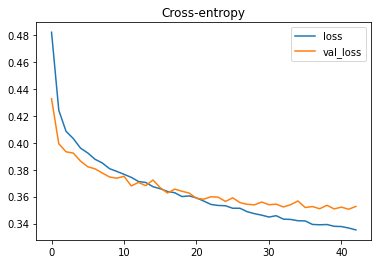

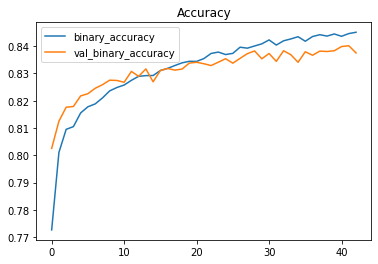

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.BatchNormalization(input_shape=input_shape), 
                          layers.Dense(256, activation='relu'), layers.BatchNormalization(), layers.Dropout(0.3), 
                         layers.Dense(256, activation='relu'), layers.BatchNormalization(), layers.Dropout(0.3), 
                         layers.Dense(1, activation='sigmoid'),])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
